In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/quorainsincerecleaned/final-cleaned-dataset.csv


In [2]:
import gensim
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
df=pd.read_csv("../input/quorainsincerecleaned/final-cleaned-dataset.csv")
df

,0,target
0,how do Quebec nationalist see their province a...,0
1,do you have an adopted dog how would you enco...,0
2,why do velocity affect time do velocity affec...,0
3,how do Otto von Guericke use the Magdeburg hem...,0
4,can I convert montra helicon d to a mountain b...,0
...,...,...
1306117,what other technical skill do you need as a co...,0
1306118,do MS in ECE have good job prospect in USA or ...,0
1306119,be foam insulation toxic,0
1306120,how can one start a research project base on b...,0


In [6]:
df = df.dropna()
questions=df["0"]

In [7]:
questions=questions.apply(gensim.utils.simple_preprocess)

In [8]:
questions

0          [how, do, quebec, nationalist, see, their, pro...
1          [do, you, have, an, adopted, dog, how, would, ...
2          [why, do, velocity, affect, time, do, velocity...
3          [how, do, otto, von, guericke, use, the, magde...
4          [can, convert, montra, helicon, to, mountain, ...
                                 ...                        
1306117    [what, other, technical, skill, do, you, need,...
1306118    [do, ms, in, ece, have, good, job, prospect, i...
1306119                        [be, foam, insulation, toxic]
1306120    [how, can, one, start, research, project, base...
1306121    [who, win, in, battle, between, wolverine, and...
Name: 0, Length: 1306121, dtype: object

# **Word2vec MODEL**

In [9]:
model = gensim.models.Word2Vec(
    window=10,
    min_count=2,
    workers=4,
)

In [10]:
model.build_vocab(questions, progress_per=1000)

In [11]:
model.train(questions, total_examples=model.corpus_count, epochs=model.epochs)

(56491144, 79590230)

In [20]:
#model.save("quora-word2vec.model")

In [12]:
model.wv.most_similar("farmer")

[('goverment', 0.6201215982437134),
 ('cattle', 0.6183046102523804),
 ('farm', 0.6146623492240906),
 ('farming', 0.6070213317871094),
 ('subsidy', 0.6054706573486328),
 ('demonetisation', 0.5746342539787292),
 ('government', 0.5679012537002563),
 ('economy', 0.567150890827179),
 ('plantation', 0.5629101395606995),
 ('cow', 0.5612945556640625)]

In [13]:
model.wv.similarity(w1="prawn",w2="pawn")

0.22310525

In [14]:
vocab_size=len(model.wv.key_to_index)
vocab_size

77131

In [15]:
model.wv.key_to_index.get("quebec",None)

5452

# **TEXT VECTORIZATION**

In [16]:
def vectorize(data,vocab):
    res=[]
    count=len(data)
    for row in data:
        row_res=[]
        for word in row:
            index=model.wv.key_to_index.get(word,None)
            if(index!=None):
                row_res.append(index)
        res.append(row_res)
        
        #counter
        count=count-1
        if(count%100000==0):
            print("remaining no of rows:",count)
        #counter
        
    return res

In [17]:
input_length = 300
X_pad = pad_sequences(
    sequences=vectorize(questions, vocab=model.wv.key_to_index),
    maxlen=input_length,
    padding='post')
print('Transform sentences to sequences... (done)')

remaining no of rows: 1300000
remaining no of rows: 1200000
remaining no of rows: 1100000
remaining no of rows: 1000000
remaining no of rows: 900000
remaining no of rows: 800000
remaining no of rows: 700000
remaining no of rows: 600000
remaining no of rows: 500000
remaining no of rows: 400000
remaining no of rows: 300000
remaining no of rows: 200000
remaining no of rows: 100000
remaining no of rows: 0
Transform sentences to sequences... (done)


# **Spltting the Data set**

In [18]:
from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test=train_test_split(X_pad,df["target"],test_size=0.2,random_state=42)

In [19]:
embedding_matrix=model.wv.vectors

# **MODEL**

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional,LSTM,Dense,Dropout,Embedding,Flatten

In [24]:
lstm_model=Sequential([
    Embedding(
        input_dim = embedding_matrix.shape[0],
        output_dim = embedding_matrix.shape[1], 
        input_length = input_length,
        weights = [embedding_matrix],
        trainable=False),
    Bidirectional(LSTM(64,return_sequences=True)),
    Dropout(0.2),
    Bidirectional(LSTM(32)),
    Dense(10,activation='relu'),
    Dropout(0.4),
    Dense(1,activation='sigmoid')
])

lstm_model.compile(
    loss="binary_crossentropy",
    optimizer='adam',
    metrics=['accuracy'])

In [22]:
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 100)          7713100   
_________________________________________________________________
bidirectional (Bidirectional (None, 300, 128)          84480     
_________________________________________________________________
dropout (Dropout)            (None, 300, 128)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense (Dense)                (None, 10)                650       
_________________________________________________________________
dropout_1 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1

In [25]:
lstm_model.fit(x_train,y_train,epochs=3)

2022-08-31 07:24:35.267886: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1253875200 exceeds 10% of free system memory.


Epoch 1/3
32653/32653 [==============================] - 1597s 49ms/step - loss: 0.1290 - accuracy: 0.9492
Epoch 2/3
32653/32653 [==============================] - 1594s 49ms/step - loss: 0.1176 - accuracy: 0.9526
Epoch 3/3
32653/32653 [==============================] - 1599s 49ms/step - loss: 0.1140 - accuracy: 0.9539


In [26]:
lstm_model.evaluate(x_test,y_test)

8164/8164 [==============================] - 172s 21ms/step - loss: 0.1048 - accuracy: 0.9582


[0.10477418452501297, 0.9582160711288452]

*Saving the model for future use*

In [27]:
lstm_model.save("w2v+LSTM_model")

2022-08-31 08:48:26.142168: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


In [70]:
from sklearn.metrics import confusion_matrix,classification_report

In [54]:
y_pred=lstm_model.predict(x_test)

In [57]:
y_p=[]
for i in y_pred:
    if(i>=0.5):
        y_p.append(1)
    else:
        y_p.append(0)

# **CONFUSION MATRIX**

In [59]:
confusion=confusion_matrix(y_test,y_p)
confusion

array([[241564,   3569],
       [  7346,   8746]])

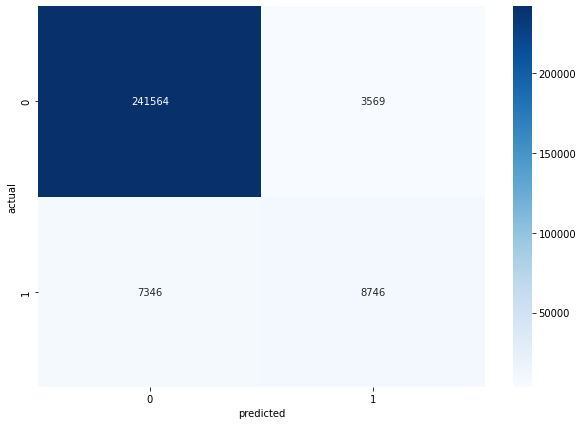

In [75]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize = (10,7))
sns.heatmap(confusion, annot=True,fmt='g',cmap='Blues')
plt.ylabel("actual")
plt.xlabel('predicted');

# **CLASSIFICATION REPORT - PRECISION, RECALL, F1 SCORE**


In [74]:
print("     Classification report of Word2vec + LSTM model\n")
print(classification_report(y_test,y_p))

     Classification report of Word2vec + LSTM model

              precision    recall  f1-score   support

           0       0.97      0.99      0.98    245133
           1       0.71      0.54      0.62     16092

    accuracy                           0.96    261225
   macro avg       0.84      0.76      0.80    261225
weighted avg       0.95      0.96      0.96    261225



**F1 score is not very impressive**